In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from msapy import msa, plottings as pl
from netneurotools import cluster, plotting as netplot # comment out the import line 15 in plotting if you got an error here
import bct

from itertools import product
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from echoes import ESNGenerator
from echoes.datasets import load_mackeyglasst17
from scipy.stats import ks_2samp, linregress
from copy import deepcopy
import networkx as nx
from tqdm import tqdm

In [96]:
SEED = 2022
RNG = np.random.default_rng(SEED)

pl.set_style()
my_colors = ['#006685', '#3FA5C4', '#FFFFFF', '#E84653', '#BF003F']
my_complementary_colors = ['#E84653', '#BF003F','#A6587C','#591154','#260126']
colormap = sns.blend_palette(my_colors, as_cmap=True)

In [97]:
def generate_wave_data(amp_freq_pairs, timestamps, sampling_rate):
    """A function to generate wave data from an array of amplitude and frequency pairs.
    We use this function to generate some toy examples for illustrating what causal modes are. 

    Args:
        amp_freq_pairs (ndarray): 
            numpy array of shape (n, 2) with n means the number of different amplitude and frequency pairs.
            
        timestamps (ndarray): 
            numpy array of shape (t,) with t means the number of timestamps.
            
        sampling_rate (float): 
            a float number representing the sampling rate.

    Returns:
        _type_: numpy array of shape (n, t) with n means the number of different amplitude and frequency pairs and t means the number of timestamps.
    """
    frequencies = amp_freq_pairs[:, 1, None]
    amplitudes = amp_freq_pairs[:, 0, None]
    timestamps = np.broadcast_to(
        timestamps, (amplitudes.shape[0], sampling_rate))
    data = np.sin(2 * np.pi * timestamps * frequencies) * amplitudes
    return data

def linear_case(complements):
    """the most basic case. Summing the incoming timeseries. Except for the lesioned ones. So the lesion here is defined as not contributing to this sum, and thus, not existing!

    Args:
        complements (tuples): which nodes to lesion.

    Returns:
        (ndarray): the summed up timeseries.
    """
    return data.sum(0) - data[complements, :].sum(0)

doubled_case = lambda x: linear_case(x)*2 # this is the case where we multiply the summed up signal by 2.

non_linear_case = lambda x: np.tanh(linear_case(x)) # this is the case where we pass the summed up signal through a nonlinearity, here it's tanh.



In [98]:
SAMPLING_RATE = 500
SAMPLING_INTERVAL = 1/SAMPLING_RATE
timestamps = np.arange(0, 1, SAMPLING_INTERVAL)

frequencies = np.arange(1, 10, 1.5)
amplitudes = np.arange(0.2, 2, 0.4)

amp_freq_pairs = np.array(list(map(list, product(amplitudes, frequencies))))

In [99]:
data = generate_wave_data(amp_freq_pairs, timestamps, SAMPLING_RATE)
elements = list(range(len(data)))

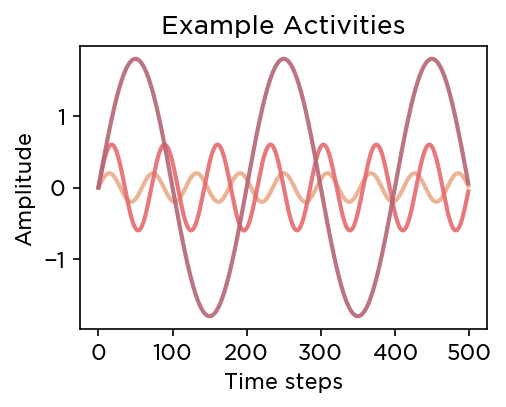

In [181]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(data[5], label="node 5",c="#EAAC8B",lw=2,alpha=0.9)
plt.plot(data[10], label="node 10",c="#E56B6F",lw=2,alpha=0.9)
plt.plot(data[25], label="node 25",c="#B56576",lw=2,alpha=0.9)
plt.title("Example Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude");

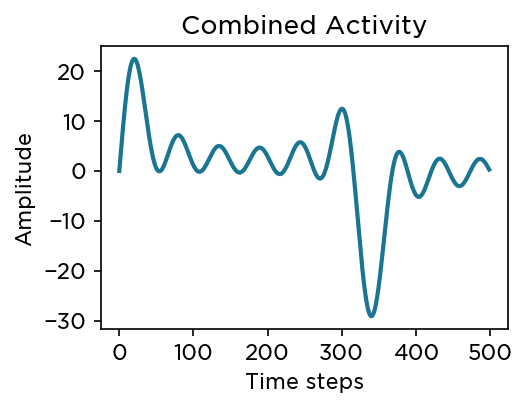

In [182]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("Combined Activity")
plt.xlabel("Time steps")
plt.ylabel("Amplitude");

In [102]:
shapley_table_linear, _, _ = msa.interface(
    elements=elements,
    n_permutations=1_000,
    objective_function=linear_case,
    n_parallel_games=-1,
    rng=RNG)
linear_modes = shapley_table_linear.groupby(level=1).mean()

Playing the games: 100%|██████████| 25556/25556 [00:01<00:00, 20457.74it/s]


In [103]:
EXAMPLE1 = 5
EXAMPLE2 = 15

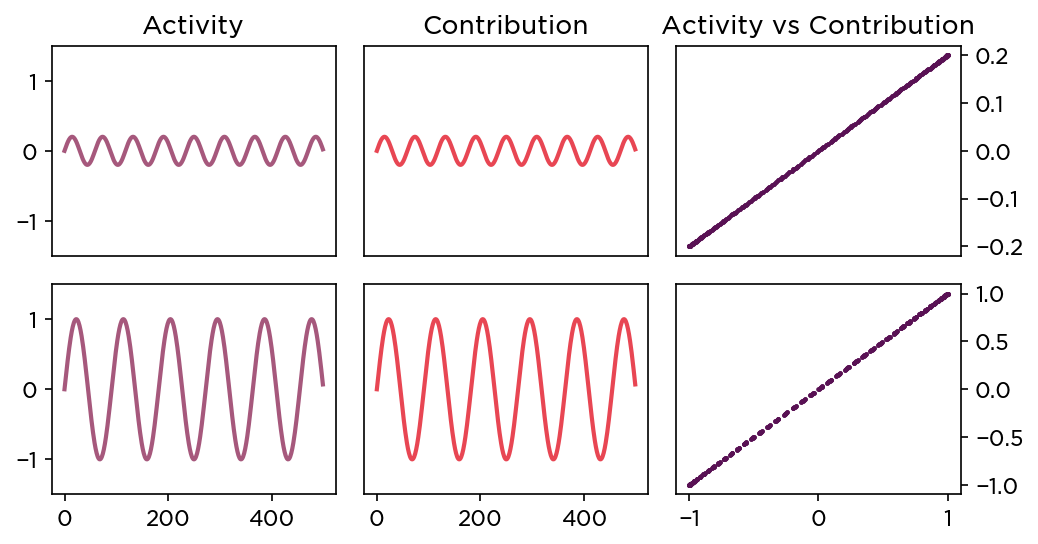

In [104]:
fig,axes = plt.subplot_mosaic(
    [['A','C','E'],
     ['B','D','F']],figsize=(7,3.5),dpi=150)
axes['A'].plot(data[EXAMPLE1], label="node 5",c=my_complementary_colors[2],lw=2)
axes['B'].plot(data[EXAMPLE2], label="node 10",c=my_complementary_colors[2],lw=2)


axes['C'].plot(linear_modes[EXAMPLE1], label="Contribution #5",c=my_complementary_colors[0],lw=2)
axes['D'].plot(linear_modes[EXAMPLE2], label="Contribution #10",c=my_complementary_colors[0],lw=2)

axes['E'].scatter(data[EXAMPLE1], linear_modes[EXAMPLE1],c=my_complementary_colors[-2],s=1.5)
axes['F'].scatter(data[EXAMPLE2], linear_modes[EXAMPLE2],c=my_complementary_colors[-2],s=1.5)

for ax in ['C','D']:
    axes[ax].yaxis.set_visible(False)
    
for ax in ['A','C','E']:
    axes[ax].xaxis.set_visible(False)

for ax in ['E','F']:
    axes[ax].yaxis.tick_right()
    
for i in ['A','B','C','D',]:
    axes[i].set_ylim([-1.5,1.5])
fig.tight_layout(pad=1)

axes['A'].title.set_text('Activity')
axes['C'].title.set_text('Contribution')
axes['E'].title.set_text('Activity vs Contribution')


Text(0, 0.5, 'Amplitude')

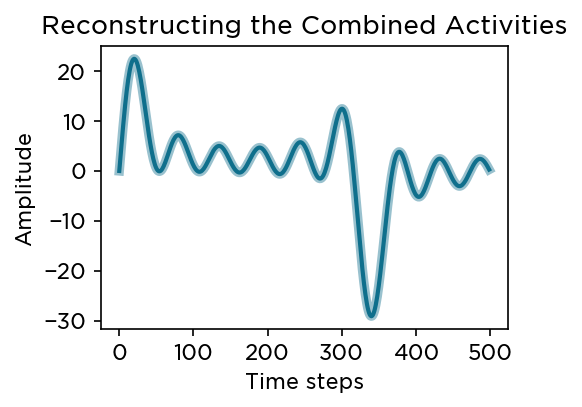

In [183]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.plot(linear_modes.sum(1),c=my_colors[0],lw=4.5,alpha=0.4)
plt.title("Reconstructing the Combined Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

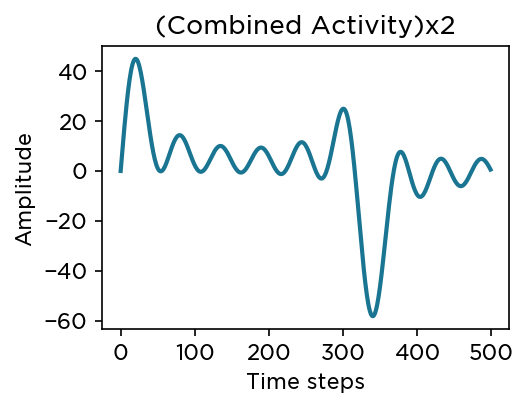

In [184]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(doubled_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("(Combined Activity)x2")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

In [107]:
shapley_table_squared, _, _ = msa.interface(
    elements=elements,
    n_permutations=1_000,
    objective_function=doubled_case,
    n_parallel_games=-1,
    rng=RNG)
squared_modes = shapley_table_squared.groupby(level=1).mean()

Playing the games: 100%|██████████| 25564/25564 [00:01<00:00, 20938.17it/s]


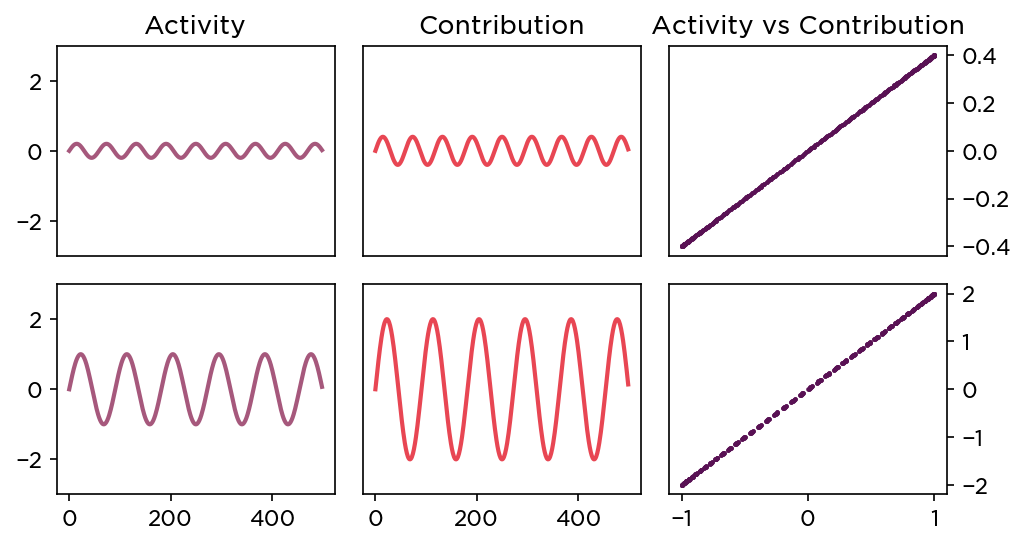

In [108]:
fig,axes = plt.subplot_mosaic(
    [['A','C','E'],
     ['B','D','F']],figsize=(7,3.5),dpi=150)
axes['A'].plot(data[EXAMPLE1], label="node 5",c=my_complementary_colors[2],lw=2)
axes['B'].plot(data[EXAMPLE2], label="node 10",c=my_complementary_colors[2],lw=2)


axes['C'].plot(squared_modes[EXAMPLE1], label="Contribution #5",c=my_complementary_colors[0],lw=2)
axes['D'].plot(squared_modes[EXAMPLE2], label="Contribution #10",c=my_complementary_colors[0],lw=2)

axes['E'].scatter(data[EXAMPLE1], squared_modes[EXAMPLE1],c=my_complementary_colors[-2],s=1.5)
axes['F'].scatter(data[EXAMPLE2], squared_modes[EXAMPLE2],c=my_complementary_colors[-2],s=1.5)

for ax in ['C','D']:
    axes[ax].yaxis.set_visible(False)
    
for ax in ['A','C','E']:
    axes[ax].xaxis.set_visible(False)

for ax in ['E','F']:
    axes[ax].yaxis.tick_right()
    
for i in ['A','B','C','D',]:
    axes[i].set_ylim([-3,3])
fig.tight_layout(pad=1)

axes['A'].title.set_text('Activity')
axes['C'].title.set_text('Contribution')
axes['E'].title.set_text('Activity vs Contribution')

Text(0, 0.5, 'Amplitude')

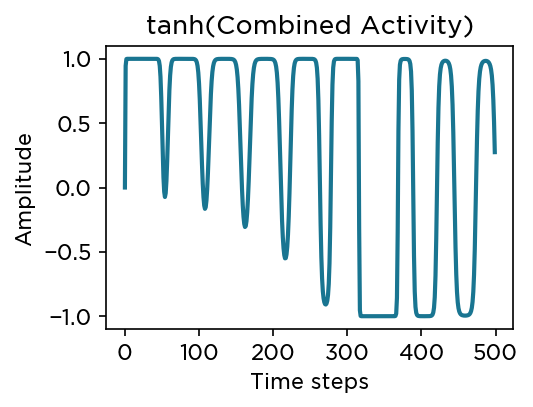

In [185]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(non_linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("tanh(Combined Activity)")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

In [110]:
shapley_table_nonlinear, _, _ = msa.interface(
    elements=elements,
    n_permutations=1_000,
    objective_function=non_linear_case,
    n_parallel_games=-1,
    rng=RNG)
nonlinear_modes = shapley_table_nonlinear.groupby(level=1).mean()

Playing the games: 100%|██████████| 25565/25565 [00:01<00:00, 16073.79it/s]


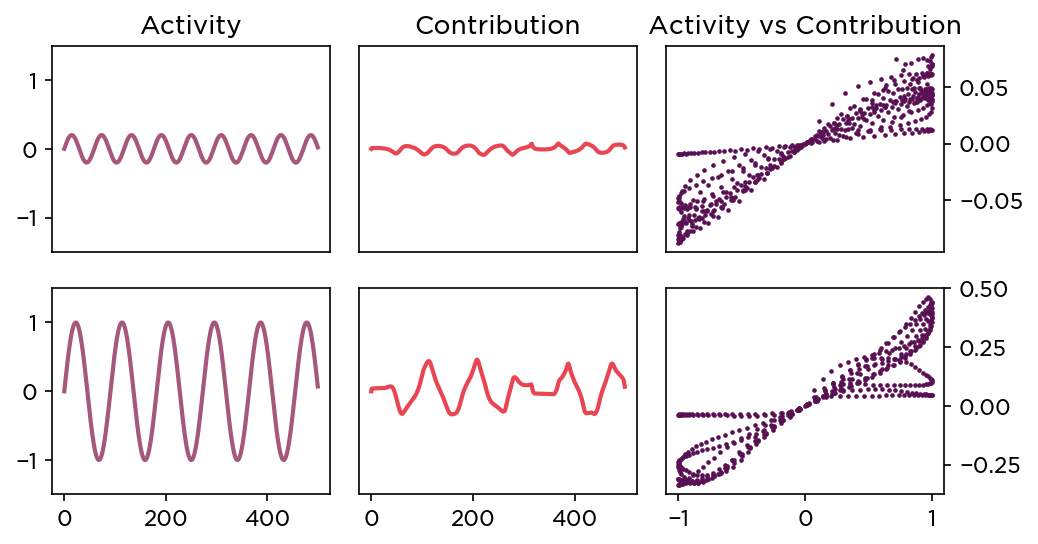

In [111]:
fig,axes = plt.subplot_mosaic(
    [['A','C','E'],
     ['B','D','F']],figsize=(7,3.5),dpi=150)
axes['A'].plot(data[EXAMPLE1], label="node 5",c=my_complementary_colors[2],lw=2)
axes['B'].plot(data[EXAMPLE2], label="node 10",c=my_complementary_colors[2],lw=2)


axes['C'].plot(nonlinear_modes[EXAMPLE1], label="Contribution #5",c=my_complementary_colors[0],lw=2)
axes['D'].plot(nonlinear_modes[EXAMPLE2], label="Contribution #10",c=my_complementary_colors[0],lw=2)

axes['E'].scatter(data[EXAMPLE1], nonlinear_modes[EXAMPLE1],c=my_complementary_colors[-2],s=1.5)
axes['F'].scatter(data[EXAMPLE2], nonlinear_modes[EXAMPLE2],c=my_complementary_colors[-2],s=1.5)

for ax in ['C','D']:
    axes[ax].yaxis.set_visible(False)
    
for ax in ['A','C','E']:
    axes[ax].xaxis.set_visible(False)

for ax in ['E','F']:
    axes[ax].yaxis.tick_right()
    
for i in ['A','B','C','D',]:
    axes[i].set_ylim([-1.5,1.5])
fig.tight_layout(pad=1)

axes['A'].title.set_text('Activity')
axes['C'].title.set_text('Contribution')
axes['E'].title.set_text('Activity vs Contribution')

In [112]:
mackey_ts = load_mackeyglasst17()
y_train, y_test = train_test_split(mackey_ts[:2500],
                                   train_size=2000,
                                   test_size=500,
                                   shuffle=False)

y_train_validate, y_test_validate = train_test_split(mackey_ts[:3500],
                                                     train_size=3000,
                                                     test_size=500,
                                                     shuffle=False)
# Constructing connectomes and defining the parameters
rng = np.random.default_rng(seed=SEED)
smallworld = nx.generators.watts_strogatz_graph(36, 6, 0.4, seed=SEED)
connectivity_matrix = nx.to_numpy_array(smallworld)

ser_connectome = connectivity_matrix * rng.uniform(low=0.1,
                                          high=1,
                                          size=(len(connectivity_matrix), len(connectivity_matrix)))

# randomly assigning weights 50 times to have 50 ESN connectomes. This'll make the network more robust.
esn_weights = [connectivity_matrix * rng.uniform(low=-0.5,
                                        high=0.5,
                                        size=(len(connectivity_matrix), len(connectivity_matrix))) for _ in range(50)]

parameter_space = list(ParameterGrid({'radius': np.linspace(0.5, 1, 20),
                                      'W': esn_weights}))
esn = ESNGenerator(n_steps=500,
                   spectral_radius=None,  # to be filled during the hyperparameter tuning
                   leak_rate=0.1,
                   random_state=SEED,
                   W=None,  # to be filled during the hyperparameter tuning
                   W_fb=rng.integers(-1, 1, len(connectivity_matrix)).reshape(-1, 1),
                   W_in=rng.uniform(-1, 1, len(connectivity_matrix)).reshape(-1, 1),
                   bias=0.001)
# Finding the best weights and spectral radius (hyperparameter tuning):
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    esn.spectral_radius = parameters['radius']
    esn.W = parameters['W']
    esn.fit(X=None, y=y_train)
    y_pred = esn.predict()
    parameters.update({'error': mean_squared_error(y_test, y_pred)})

optimum_params = min(parameter_space, key=lambda x: x['error'])  # the combination with the minimum MSE

Optimizing hyperparams: 100%|██████████| 1000/1000 [00:32<00:00, 30.97it/s]


In [113]:
# testing the network.
esn.spectral_radius = optimum_params['radius']
esn.W = optimum_params['W']
esn.store_states_pred=True
esn.fit(X=None, y=y_train_validate)

y_pred = esn.predict()
mse = mean_squared_error(y_test_validate, y_pred)

print(f'MSE: {mse:.2}, Optimal Spectral Radius: {optimum_params["radius"]:.2}')

MSE: 0.0049, Optimal Spectral Radius: 0.66


In [114]:
def lesion_esn(complements, network, training_data):
    """the function that lesions the ESN. This is basically our "game" where we derive the causal modes from.

    Args:
        complements (tuple): which nodes to lesion at every iteration.
        network (echoes.ESNGenerator): the trained ESN object.
        training_data (ndarray): just the training data so we can fit the network to it in each iteration.

    Returns:
        (ndarray): squeezed prediction vector of the lesioned network.
    """

    if len(complements) == len(network.W):
        return np.zeros(500) # if we lesion all the nodes, we return a vector of zeros instead of playing the game.

    lesioned_network = deepcopy(network)
    for target in complements:  # setting weights to zero (very close to zero due to practical issues that come with the actual zero values)
        lesioned_network.W[target,:] = 0.00001
        lesioned_network.W[:,target] = 0.00001
        lesioned_network.W_fb[target] = 0.00001
        lesioned_network.W_in[target] = 0.00001

    lesioned_network.fit(X=None, y=training_data)
    y_pred = lesioned_network.predict().squeeze()  

    return y_pred

In [89]:
lesion_esn_params = {'network': esn, 'training_data': y_train_validate}
shapley_table_esn, _, _ = msa.interface(multiprocessing_method='joblib',
                                    elements=list(range(esn.n_reservoir_)),
                                    n_permutations=1_000,
                                    objective_function=lesion_esn,
                                    objective_function_params=lesion_esn_params,
                                    n_parallel_games=-1,
                                    random_seed=SEED)
esn_modes = shapley_table_esn.groupby(level=1).mean()

Playing the games: 100%|██████████| 31953/31953 [01:15<00:00, 424.06it/s]


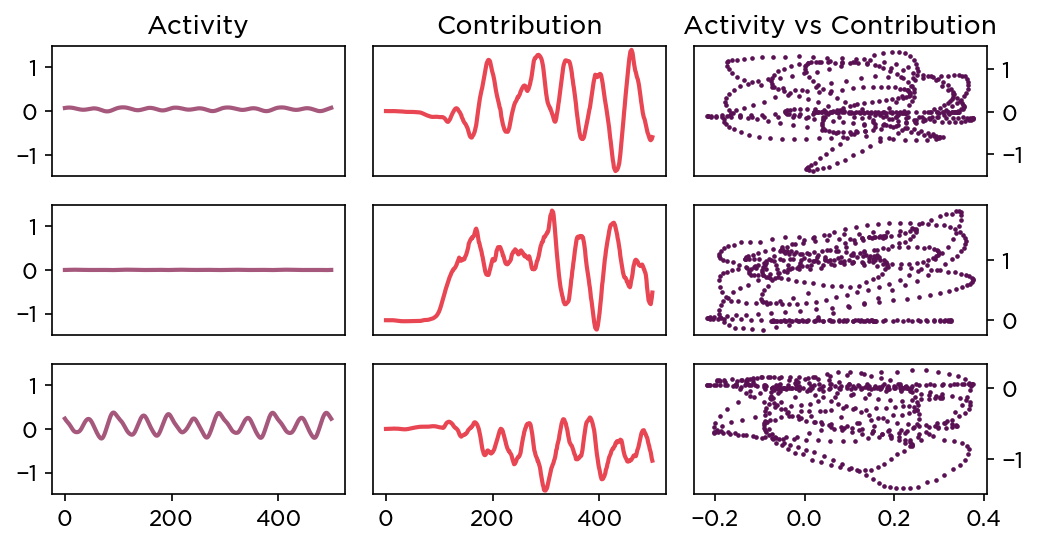

In [141]:
EXAMPLE1 = 3
EXAMPLE2 = 12
EXAMPLE3 = 32
fig,axes = plt.subplot_mosaic(
    [['A','C','E'],
     ['X','Y','Z'],
     ['B','D','F']],figsize=(7,3.5),dpi=150)
axes['A'].plot(esn.states_pred_.T[EXAMPLE1], c=my_complementary_colors[2],lw=2)
axes['X'].plot(esn.states_pred_.T[EXAMPLE3], c=my_complementary_colors[2],lw=2)
axes['B'].plot(esn.states_pred_.T[EXAMPLE2], c=my_complementary_colors[2],lw=2)

axes['C'].plot(esn_modes[EXAMPLE1], c=my_complementary_colors[0],lw=2)
axes['Y'].plot(esn_modes[EXAMPLE3], c=my_complementary_colors[0],lw=2)
axes['D'].plot(esn_modes[EXAMPLE2], c=my_complementary_colors[0],lw=2)

axes['E'].scatter(esn.states_pred_.T[EXAMPLE1], esn_modes[EXAMPLE1],c=my_complementary_colors[-2],s=1.5)
axes['Z'].scatter(esn.states_pred_.T[EXAMPLE3], esn_modes[EXAMPLE3],c=my_complementary_colors[-2],s=1.5)
axes['F'].scatter(esn.states_pred_.T[EXAMPLE2], esn_modes[EXAMPLE2],c=my_complementary_colors[-2],s=1.5)

for ax in ['C','D','Y',]:
    axes[ax].yaxis.set_visible(False)
    
for ax in ['A','C','E','X','Y','Z']:
    axes[ax].xaxis.set_visible(False)

for ax in ['E','F','Z']:
    axes[ax].yaxis.tick_right()
    
for i in ['A','B','C','D','X',]:
    axes[i].set_ylim([-1.5,1.5])
fig.tight_layout(pad=1)

axes['A'].title.set_text('Activity')
axes['C'].title.set_text('Contribution')
axes['E'].title.set_text('Activity vs Contribution')

/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

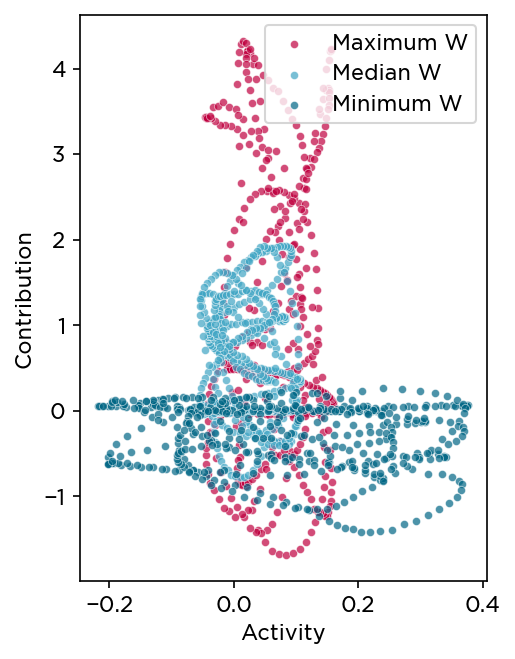

In [172]:
median_index = np.argsort(np.abs(esn.W_out_).squeeze())[len(esn.W_out_.squeeze())//2]
plt.figure(figsize=(3.5,5),dpi=150)
sns.scatterplot(esn.states_pred_.T[np.argmax(np.abs(esn.W_out_))],esn_modes[np.argmax(np.abs(esn.W_out_))].squeeze(),color=my_colors[-1],alpha=0.7,s=15,label='Maximum W')
sns.scatterplot(esn.states_pred_.T[median_index],esn_modes[median_index].squeeze(),color=my_colors[1],alpha=0.7,s=15,label='Median W')
sns.scatterplot(esn.states_pred_.T[np.argmin(np.abs(esn.W_out_[0,:-1]))],esn_modes[np.argmin(np.abs(esn.W_out_[0,:-1]))].squeeze(),color=my_colors[0],alpha=0.7,s=15,label='Minimum W')
fig.legend()
plt.ylabel('Contribution')
plt.xlabel('Activity');


Text(0, 0.5, 'Amplitude')

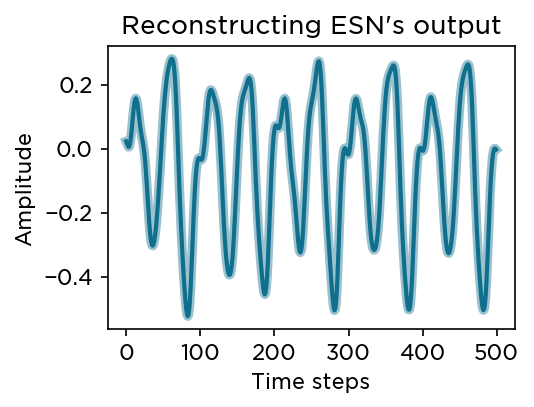

In [180]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(y_pred.squeeze(),c=my_colors[0],lw=2,alpha=0.9)
plt.plot(esn_modes.sum(axis=1),c=my_colors[0],lw=4.5,alpha=0.4)
plt.title("Reconstructing ESN's output")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

In [186]:
mean_squared_error(y_pred.squeeze(),esn_modes.sum(axis=1))

1.0926512149963582e-30

In [187]:
modes_similarities = np.array(esn_modes.corr())
fc = np.corrcoef(esn.states_pred_.T)

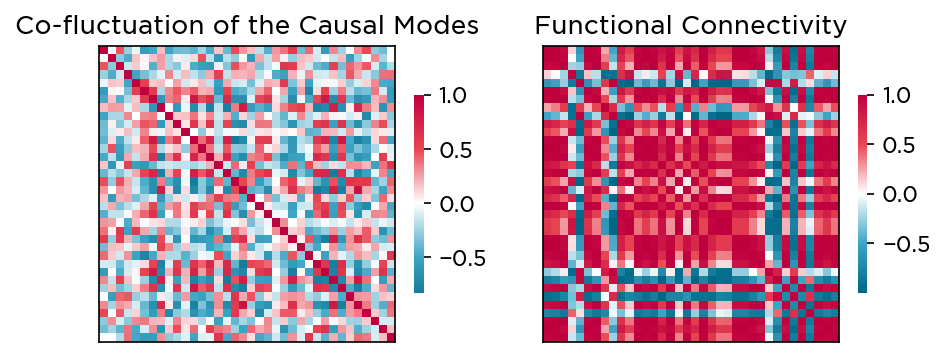

In [194]:
#cbar_ax = fig.add_axes([.92, .2, .01, .1])
fig,axes = plt.subplot_mosaic(
    [['A','B']],figsize=(7,3.5),dpi=150)
sns.heatmap(modes_similarities,square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},ax=axes['A'],xticklabels=False,yticklabels=False)
sns.heatmap(fc,square=True,
            cmap=colormap,center=0,cbar_kws={"shrink": .5},ax=axes['B'],xticklabels=False,yticklabels=False)
axes['A'].title.set_text('Co-fluctuation of the Causal Modes')
axes['B'].title.set_text('Functional Connectivity')

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

In [195]:
GAMMA = 1.
mode_communities = [bct.clustering.modularity_louvain_und_sign(modes_similarities, gamma=GAMMA)[0] for _ in range(1000)]
mode_consensus = cluster.find_consensus(np.column_stack(mode_communities), seed=SEED)
fc_communities = [bct.clustering.modularity_louvain_und_sign(fc, gamma=GAMMA)[0] for _ in range(1000)]
fc_consensus = cluster.find_consensus(np.column_stack(fc_communities), seed=SEED)


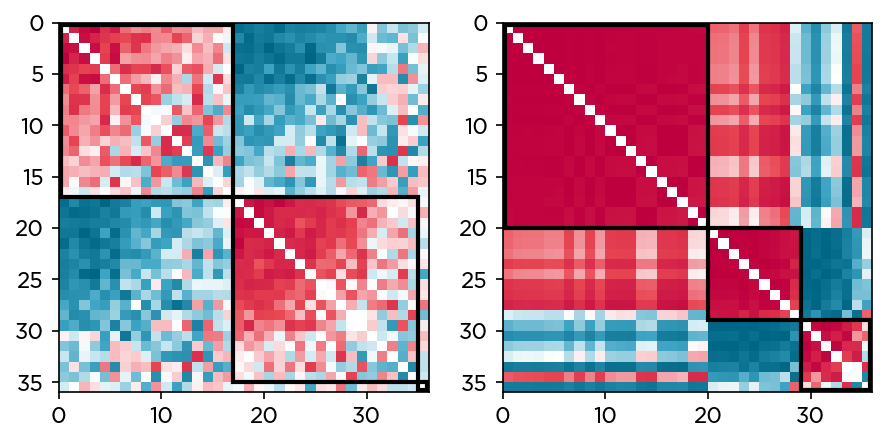

In [197]:
fig,axes = plt.subplot_mosaic([['A','B']],figsize=(7,3.5),dpi=150)
netplot.plot_mod_heatmap(modes_similarities, mode_consensus, cmap=colormap,ax=axes['A'],cbar=False)
netplot.plot_mod_heatmap(fc, fc_consensus, cmap=colormap,ax=axes['B'],cbar=False,)
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

In [198]:
nonnegative_modes = modes_similarities.copy()
nonnegative_modes[modes_similarities<0] = 0

nonnegative_fc = fc.copy()
nonnegative_fc[fc<0] = 0

In [199]:
ks_index=[]
for i in range(len(esn_modes.T)):
    temp=[]
    temp,_=ks_2samp(np.array(esn.states_pred_.T[i]),np.array(esn_modes[i]))
    ks_index.append(temp)


(-0.05, 0.7)

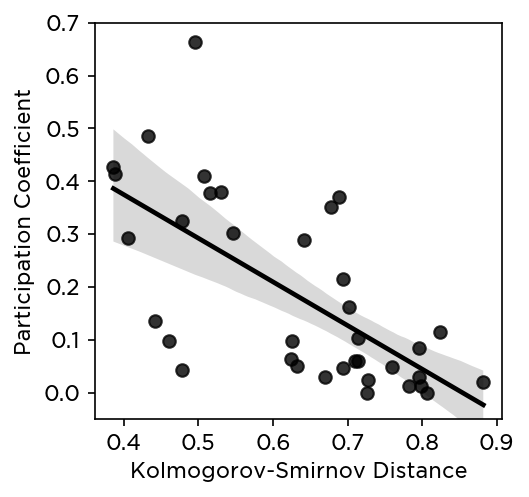

In [211]:
pc = bct.participation_coef(nonnegative_modes, mode_consensus)
data=pd.DataFrame({'ks':ks_index,'pc':pc})
plt.figure(figsize=(3.5,3.5),dpi=150)
sns.regplot(x='ks',y='pc',data=data,truncate=True,color='k')
linregress(ks_index,pc)
plt.ylabel('Participation Coefficient')
plt.xlabel('Kolmogorov-Smirnov Distance')
plt.ylim([-0.05,0.7])

In [ ]:
structural_communities = [bct.community_louvain(connectivity_matrix, gamma=GAMMA)[0] for n in range(1000)]

structural_consensus = cluster.find_consensus(np.column_stack(structural_communities), seed=SEED)
netplot.plot_mod_heatmap(esn.W, structural_consensus, cmap=colormap)

In [ ]:
from network_control.utils import matrix_normalization
from network_control.metrics import ave_control, modal_control
A = matrix_normalization(np.abs(esn.W), c=1, version='discrete')
mc = modal_control(A)
ac = ave_control(A)

In [ ]:
test = mc
sns.regplot(ks_index,test)
linregress(ks_index,test)